## Play with emulator covariance

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace_manager.data import data_MPGADGET
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace_manager.likelihood import full_theory
from lace_manager.likelihood import likelihood
from lace_manager.sampler import iminuit_minimizer

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="central"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
z_max=4.5
emu_type="polyfit"
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,sim_label=test_sim_label,
                                zmax=z_max,polyfit=(emu_type=="polyfit"))

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = -5.5511E-17, Omega_nu h^2 = 0.0000E+00, A_s = 2.0061E-09, n_s = 9.6757E-01, alpha_s = 0.0000E+00


### Emulator and training set

Create a set of training data to train an emulator

In [4]:
# Setup archive of P1D entries
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,z_max=z_max,
                            drop_tau_rescalings=True,drop_temp_rescalings=True)
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']

In [5]:
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type=emu_type,passarchive=archive,
                                kmax_Mpc=kmax_Mpc,
                                check_hull=True)

 /Users/font/opt/anaconda3/envs/lace_env/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 330 points
GPs optimised in 0.25 seconds


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [6]:
if True:
    free_param_limits=[[1.1e-09, 3.19e-09], [0.89, 1.05],
                   [-0.2, 0.2],[-0.2, 0.2],[-0.2, 0.2],[-0.2, 0.2],
                   [-0.2, 0.2],[-0.2, 0.2],[-0.2, 0.2],[-0.2, 0.2]]
    free_param_names=["As","ns","ln_tau_0","ln_tau_1","ln_sigT_kms_0","ln_sigT_kms_1",
                  "ln_gamma_0","ln_gamma_1","ln_kF_0","ln_kF_1"]
else:
    free_param_limits=[[1.1e-09, 3.19e-09], [0.89, 1.05],[-0.2, 0.2]]
    free_param_names=["As","ns","ln_tau_0"]    
Np=len(free_param_names)
prior=None

In [7]:
emu_cov_factor=1
like=likelihood.Likelihood(data=data,emulator=emu,
                           free_param_names=free_param_names,
                           prior_Gauss_rms=prior,
                           include_CMB=False,
                           emu_cov_factor=emu_cov_factor)

4.5 outside hull {'Delta2_p': 0.19404961562240766, 'n_p': -2.302619176729605, 'alpha_p': -0.21536141627397162, 'mF': 0.21484023874597408, 'gamma': 1.4333671132654395, 'sigT_Mpc': 0.09836390937911826, 'kF_Mpc': 14.738186021221429}


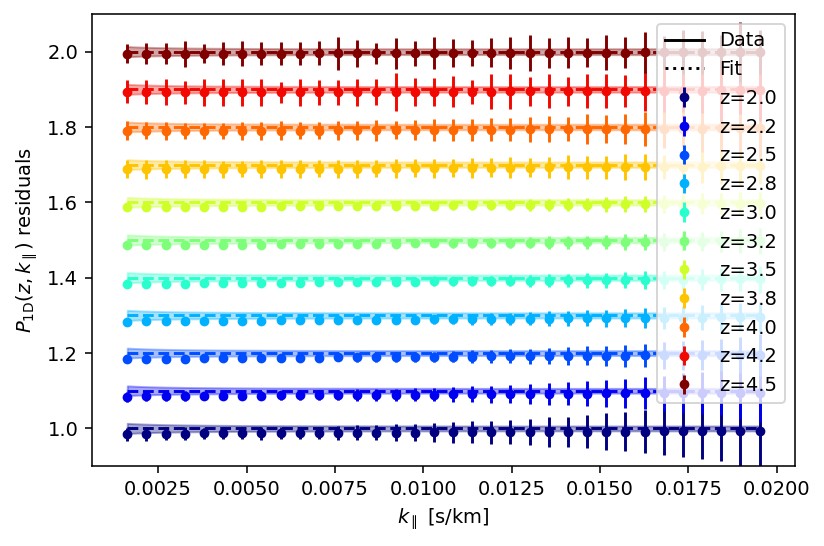

In [8]:
like.plot_p1d(residuals=True)

In [9]:
def plot_cov(values=None,zplot=4):
    if not values: values=Np*[0.5]
        
    k_kms=data.k  
    emu_info=like.get_p1d_kms(k_kms=k_kms,return_covar=True,values=values)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)    
    for iz,z in enumerate(data.z):
        if iz%zplot: continue
        emu_p1d=emu_info[0][iz]
        emu_cov=emu_info[1][iz]
        emu_err=np.sqrt(np.diag(emu_cov))
        data_p1d=data.get_Pk_iz(iz)
        data_cov=data.get_cov_iz(iz)
        data_err=np.sqrt(np.diag(data_cov))
        (_,lndet_data)=np.linalg.slogdet(data_cov)
        (_,lndet_tot)=np.linalg.slogdet(data_cov+emu_cov)
        print(iz,lndet_data-lndet_tot)        
        
        ax1.plot(k_kms,data_p1d/emu_p1d,label='z={:.2f}'.format(z))

        ax2.plot(k_kms,emu_err/emu_p1d,label='emu z={:.2f}'.format(z))
        ax2.plot(k_kms,data_err/emu_p1d,':',label='data z={:.2f}'.format(z))

    ax1.set_xlabel(r'$k$ [s/km]')
    ax1.set_ylabel('data / emu')
    ax1.legend()
    
    ax2.set_xlabel(r'$k$ [s/km]')
    ax2.set_ylabel('error / P1D')
    ax2.legend()
    
    plt.tight_layout()

4.5 outside hull {'Delta2_p': 0.196627124006889, 'n_p': -2.2976191767296053, 'alpha_p': -0.21536141627397162, 'mF': 0.21484023874597408, 'gamma': 1.4333671132654395, 'sigT_Mpc': 0.09836390937911826, 'kF_Mpc': 14.738186021221429}
0 -0.9568955611836714
4 -2.5536975091046656
8 -1.00892088941022


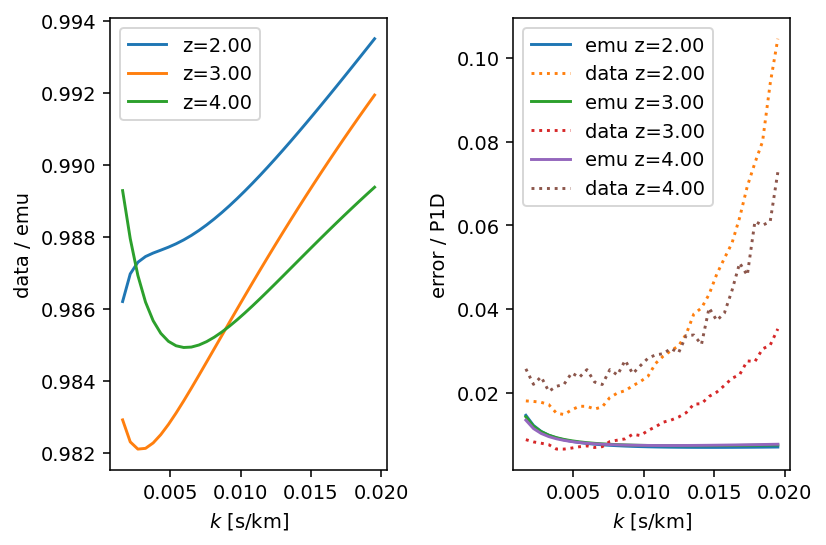

In [10]:
plot_cov(values=Np*[0.5])

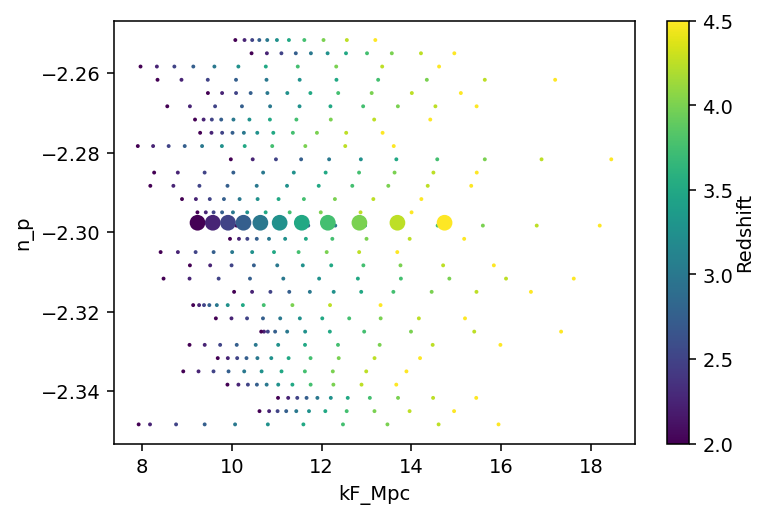

In [11]:
like.overplot_emulator_calls('kF_Mpc','n_p',values=Np*[0.5])